1. *Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.  
2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.
3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).
4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).
5. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.
6. Могла ли модель переобучиться? Почему?
7. *Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
classes = datasets.make_classification(n_samples=100, n_features=64,
                                       n_informative=32, n_redundant=0,
                                       n_classes=2, random_state=12)

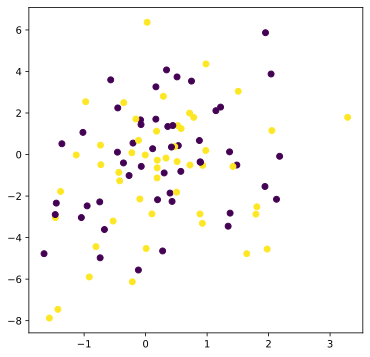

In [3]:

plt.figure(figsize=(6, 6))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1])

In [4]:
def transpose(list_array):
    new_list = []
    for el in list_array:
        print(el.shape)
        if len(el.shape) == 1:
            el = el.copy().reshape(1, el.shape[0])
            new_list.append(el)
            print(el.shape)
        else:
            el = el.copy().T
            el = np.vstack([np.ones(len(el[0])), el])
            new_list.append(el)
            print(el.shape)
    return new_list

In [5]:
def train_test_split(data, proportion=0.7):
    # перемешивание датасета
    np.random.seed(12)
    shuffle_index = np.random.permutation(data[0].shape[0])
    X_shuffled, y_shuffled = data[0][shuffle_index], data[1][shuffle_index]

    # разбивка на обучающую и тестовую выборки
    train_proportion = proportion
    train_test_cut = int(len(data[0]) * train_proportion)

    X_train, X_test, y_train, y_test = \
        X_shuffled[:train_test_cut], \
        X_shuffled[train_test_cut:], \
        y_shuffled[:train_test_cut], \
        y_shuffled[train_test_cut:]
    list_array = [X_train, X_test, y_train, y_test]
    
    X_train, X_test, y_train, y_test = transpose(list_array)

    print("Размер массива признаков обучающей выборки", X_train.shape)
    print("Размер массива признаков тестовой выборки", X_test.shape)
    print("Размер массива ответов для обучающей выборки", y_train.shape)
    print("Размер массива ответов для тестовой выборки", y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(classes)

(70, 64)
(65, 70)
(30, 64)
(65, 30)
(70,)
(1, 70)
(30,)
(1, 30)
Размер массива признаков обучающей выборки (65, 70)
Размер массива признаков тестовой выборки (65, 30)
Размер массива ответов для обучающей выборки (1, 70)
Размер массива ответов для тестовой выборки (1, 30)


In [7]:
X_train.shape

(65, 70)

y_train.shape[1]

def calc_logloss(y, y_pred):
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [63]:
class LogisticRegressor():
    
    def __init__(self, eta=0.1, max_iter=1e5, 
                 min_weight_dist=1e-8, random_state=-1, 
                 lamb=0, type_gd='gd', size_batch=0):
        self.eta = eta
        self.max_iter = int(max_iter)
        self.min_weight_dist = min_weight_dist
        self.random_state = random_state
        self.lamb = lamb
        self.type_gd = type_gd
        self.size_batch = size_batch
        if self.type_gd == 'sgd':
            self.size_batch = 1
        if self.size_batch > 1:
            self.type_gd = 'mini_batch'
        elif self.size_batch == 1:
            self.type_gd = 'sgd'
        self.weight_dist = np.inf
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def anti_overflow(self, x):
        if np.any(x > 700):
            x[x > 700] = 700
        if np.any(x < -700):
            x[x < -700] = -700
        return x
    
    def anti_zero(self, A):
        if np.any(A < 1e-6):
            A[A < 1e-6] = 1e-6
        if np.any(A == 1):
            A[A == 1] = 1 - 1e-6
        return A
    
    def calc_logloss(self, y, A):
        A = self.anti_zero(A)
        err = - np.mean(y * np.log(A) + (1.0 - y) * np.log(1.0 - A))
        return err
    
    def _log_loss(self, w, X, y):
        m = X.shape[1]
        z = self.anti_overflow(np.dot(w.T, X))
        p = self.anti_overflow(np.dot(w.T, X))
        A = self._sigmoid(z) # вероятность отнесения объекта к классу "+1"
        
        err = self.calc_logloss(y, A)
        loss = -1.0 / m * np.log(1 + np.exp(p))
        grad = 1.0 / m * np.dot(X, (A - y).T)
        
        return loss, grad, err
    
    def optimize(self, w, X, y, eta):      
        loss, grad, err = self._log_loss(w, X, y)
        w = w - eta * grad
        
        return w, loss, err
    
    def fit(self, X, target):
        list_iter, list_err, w_list, loss_list = [], [], [], []
        self.target = target
        w = np.zeros((len(X), 1))
        n = X.shape[0]
        type_gd = self.type_gd
        if self.random_state != -1:
            np.random.seed(self.random_state)
        for i in range(1, self.max_iter+1):
            if type_gd != 'gd':
                train_ind = list(np.random.randint(X.shape[0], size=self.size_batch))
                self.target_batch = self.target[0][train_ind]
                X_batch = X[:, train_ind]
            elif type_gd == 'gd':
                self.target_batch = self.target
                X_batch = X
            old_w = w.copy()
            w, loss, err = self.optimize(w, X_batch, self.target_batch, self.eta)
            norm = np.linalg.norm(w - old_w, ord=2)
#             if i == 1:
#                 print(i, w, loss, err, norm)
            if i % 10 == 0:
                list_iter.append(i)
                list_err.append(err)
                loss_list.append(loss)
            if norm < self.min_weight_dist:
                print(i, w, err)
                list_iter.append(i)
                list_err.append(err)
                loss_list.append(loss)
                break
                
        return list_iter, list_err, self.eta, w
    
    def calc_pred_proba(self, w, X):
        w = w.reshape(X.shape[0], 1)
        y_pred_proba = self._sigmoid(np.dot(w.T, X))
        
        return y_pred_proba
    
    def calc_pred(self, w, X, proba=0.5):
        m = X.shape[1]
        y_pred = np.zeros((1, m))
        A = self.calc_pred_proba(w, X)

        for i in range(A.shape[1]):
            if (A[:,i] > proba): 
                y_pred[:, i] = 1
            elif (A[:,i] <= proba):
                y_pred[:, i] = 0

        return y_pred
    
    @staticmethod
    def calc_accuracy(y_pred, y):
        accuracy = 100.0 - np.mean(np.abs(y_pred - y)*100.0)
        
        return accuracy
    
    @staticmethod
    def matrix_err(y_pred, y):
        tp = np.count_nonzero((y_pred[0] == y[0]) & (y_pred[0] == 1))
        tn = np.count_nonzero((y_pred[0] == y[0]) & (y_pred[0] == 0))
        fp = np.count_nonzero((y_pred[0] != y[0]) & (y_pred[0] == 1))
        fn = np.count_nonzero((y_pred[0] != y[0]) & (y_pred[0] == 0))
        print('TP     FP\nFN     TN')
        print(np.array([[tp, fp], [fn, tn]]))
        
        return tp, tn, fp, fn
    
    @staticmethod
    def calc_precision(y_pred, y):
        tp, tn, fp, fn = LogisticRegressor.matrix_err(y_pred, y)
        precision = tp / (tp + fp)
        
        return precision
    
    @staticmethod
    def calc_recall(y_pred, y):
        tp, tn, fp, fn = LogisticRegressor.matrix_err(y_pred, y)
        recall = tp / (tp + fn)
        
        return recall
    
    @staticmethod
    def calc_f_score(y_pred, y, beta=1):
        tp, tn, fp, fn = LogisticRegressor.matrix_err(y_pred, y)
        precision = LogisticRegressor.calc_precision(y_pred, y)
        recall = LogisticRegressor.calc_recall(y_pred, y)
        f_score = (1 + beta ** 2) * (precision * recall) / (beta ** 2 * precision + recall)
        
        return f_score


In [9]:
def grid_search(X, y, list_eta, list_iter):
    for eta in list_eta:
        for n in list_iter:
            log_r = LogisticRegressor(eta=eta, max_iter=n, random_state=12)
            iter_list, list_err, alpha, w = log_r.fit(X, y)
            print(f'Скорость обучения: {eta} \n Максимальное кол-во итераций: {n} \n \
            logloss: {list_err[-1]} \n Число итераций: {iter_list[-1]}')

In [12]:
alpha_list = [0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
iteration_list = [1e2, 1e3, 1e4, 1e5, 1e6]
grid_search(X_train, y_train, alpha_list, iteration_list)

Скорость обучения: 0.1 
 Максимальное кол-во итераций: 100.0 
             logloss: 0.03174444906778673 
 Число итераций: 100
Скорость обучения: 0.1 
 Максимальное кол-во итераций: 1000.0 
             logloss: 0.003397751891134728 
 Число итераций: 1000
Скорость обучения: 0.1 
 Максимальное кол-во итераций: 10000.0 
             logloss: 0.00034136411355081684 
 Число итераций: 10000
Скорость обучения: 0.1 
 Максимальное кол-во итераций: 100000.0 
             logloss: 3.4224430794494244e-05 
 Число итераций: 100000
Скорость обучения: 0.1 
 Максимальное кол-во итераций: 1000000.0 
             logloss: 3.3993284096831196e-06 
 Число итераций: 1000000
Скорость обучения: 0.01 
 Максимальное кол-во итераций: 100.0 
             logloss: 0.17700768470693698 
 Число итераций: 100
Скорость обучения: 0.01 
 Максимальное кол-во итераций: 1000.0 
             logloss: 0.031817565068518516 
 Число итераций: 1000
Скорость обучения: 0.01 
 Максимальное кол-во итераций: 10000.0 
             loglo

из перебранных комбинаций наименьшая ошибка у варианта со скоростью обучения 0.1 и миллионом итераций, logloss при этом составляет 3.4e-6.
со стохастическим градиеньным спуском можно получить и меньшую ошибку при значительно меньшем количестве итераций, но accuracy падает при аналогичных параметрах почти на 10% (ячейки с этим сравнением, к сожалению, удалил)

In [17]:
%%time
log_r = LogisticRegressor(eta=0.1, type_gd='gd', max_iter=1e6, random_state=12)
iter_list, list_err, eta, w = log_r.fit(X_train, y_train)

CPU times: user 10min 45s, sys: 6.41 s, total: 10min 51s
Wall time: 2min 42s


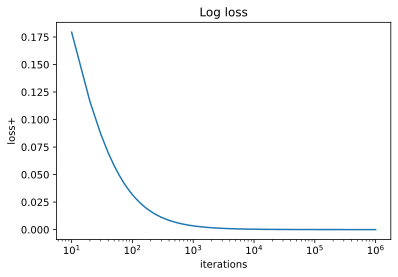

In [25]:
plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss+')
# plt.yscale('log')
plt.xscale('log')
plt.plot(iter_list, list_err)

вообще кажется, что хватило бы и 10000 итераций - потеряли бы немного))

In [38]:
y_pred_train = log_r.calc_pred(w, X_train)
y_pred_train.shape

0.5


(1, 70)

In [45]:
y_pred_test = log_r.calc_pred(w, X_test)

0.5


In [49]:
LogisticRegressor.calc_accuracy(y_pred_train, y_train), LogisticRegressor.calc_accuracy(y_pred_test, y_test)

(100.0, 73.33333333333333)

In [54]:
LogisticRegressor.matrix_err(y_pred_train, y_train)

TP     FP
FN     TN
[[42  0]
 [ 0 28]]


(42, 28, 0, 0)

In [55]:
LogisticRegressor.matrix_err(y_pred_test, y_test)

TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]


(7, 15, 7, 1)

In [61]:
# precision
print(f'train: {LogisticRegressor.calc_precision(y_pred_train, y_train)}\n\
test:{LogisticRegressor.calc_precision(y_pred_test, y_test)}')

TP     FP
FN     TN
[[42  0]
 [ 0 28]]
TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]
train: 1.0
test:0.5


In [62]:
# recall
print(f'train: {LogisticRegressor.calc_recall(y_pred_train, y_train)}\n\
test:{LogisticRegressor.calc_recall(y_pred_test, y_test)}')

TP     FP
FN     TN
[[42  0]
 [ 0 28]]
TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]
train: 1.0
test:0.875


In [64]:
print(f'train: {LogisticRegressor.calc_f_score(y_pred_train, y_train)}\n\
test:{LogisticRegressor.calc_f_score(y_pred_test, y_test)}')

TP     FP
FN     TN
[[42  0]
 [ 0 28]]
TP     FP
FN     TN
[[42  0]
 [ 0 28]]
TP     FP
FN     TN
[[42  0]
 [ 0 28]]
TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]
TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]
TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]
train: 1.0
test:0.6363636363636364


Как мы можем наблюдать - налицо переобучение и очень сильное (за миллион итераций немудрено)
Это видно по всем метрикам - 100% точность у всех метрик на train, а на test все метрики проседают

На последнее задание времени, увы, вообще нет - надо догонять с 4 дз))